<a href="https://colab.research.google.com/github/tbtraltaa/tensorflow_developer/blob/main/C4/W4/assignment/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [36]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [37]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [38]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-03-26 10:26:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-03-26 10:26:19 (5.60 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



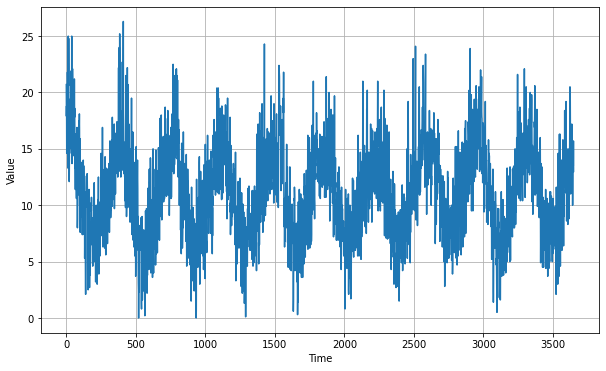

In [39]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for i, row in enumerate(reader):
    time_step.append(i)
    temps.append(float(row[1]))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [44]:
split_time = 2500
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [46]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(lambda w: (w[:-1], w[-1:]))
    return dataset.batch(batch_size).prefetch(1)

In [47]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)


In [48]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(32, kernel_size=5, strides=1, padding='causal',
                       activation='relu', input_shape=[None, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x*400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 47ms/step - loss: 31.1418 - mae: 31.6401 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 61ms/step - loss: 30.5657 - mae: 31.0639 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 61ms/step - loss: 29.6745 - mae: 30.1726 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 63ms/step - loss: 28.5571 - mae: 29.0549 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 64ms/step - loss: 27.1948 - mae: 27.6923 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 59ms/step - loss: 25.4979 - mae: 25.9952 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 60ms/step - loss: 23.3389 - mae: 23.8356 - lr: 1.9953e-08
Epoch 8/100
10/10 [===============

(1e-08, 0.0001, 0.0, 60.0)

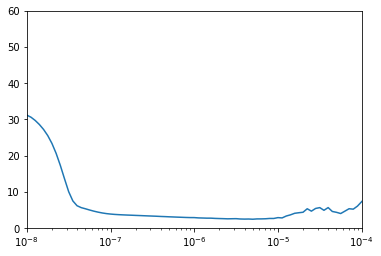

In [49]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
])


optimizer = tf.keras.optimizers.SGD(learning_rate=# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=# YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 39ms/step - loss: 9.8779 - mae: 10.3645
Epoch 2/150
25/25 [==============================] - 1s 40ms/step - loss: 2.7308 - mae: 3.1968
Epoch 3/150
25/25 [==============================] - 1s 38ms/step - loss: 2.4405 - mae: 2.9030
Epoch 4/150
25/25 [==============================] - 1s 39ms/step - loss: 2.3559 - mae: 2.8171
Epoch 5/150
25/25 [==============================] - 1s 37ms/step - loss: 2.4620 - mae: 2.9241
Epoch 6/150
25/25 [==============================] - 1s 39ms/step - loss: 2.3701 - mae: 2.8315
Epoch 7/150
25/25 [==============================] - 1s 39ms/step - loss: 2.3196 - mae: 2.7794
Epoch 8/150
25/25 [==============================] - 1s 39ms/step - loss: 2.4254 - mae: 2.8876
Epoch 9/150
25/25 [==============================] - 1s 38ms/step - loss: 2.2868 - mae: 2.7469
Epoch 10/150
25/25 [==============================] - 1s 38ms/step - loss: 2.2923 - mae: 2.7517
Epoch 11/150
25/25 [============================

In [35]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

AttributeError: ignored

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS